In [1]:
import glob
import cv2
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.cross_validation import train_test_split
from utils import *
%matplotlib inline

{'n_notcars': 9666, 'image_shape': (64, 64, 3), 'data_type': dtype('float32'), 'n_cars': 8792}


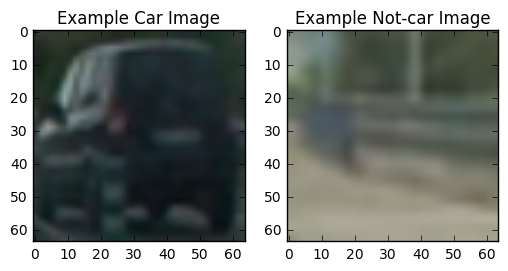

In [2]:
# Load training set
cars = []
notcars = []
images = glob.glob('dataset/vehicles/**/*.png')
for image in images:
    cars.append(image)
    
images = glob.glob('dataset/non-vehicles/**/*.png')
for image in images:
    notcars.append(image)
        
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(cars, notcars)
print(data_info)

# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')

929


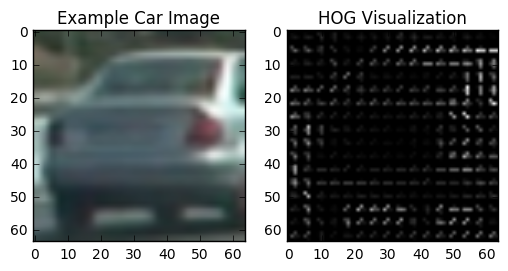

In [42]:
# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
print(ind)

# Read in the image
image = mpimg.imread(cars[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 8
pix_per_cell = 4
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis = True, feature_vec = False)

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

3789


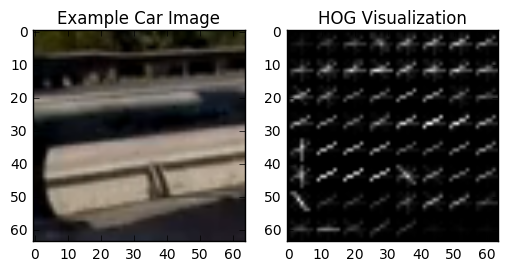

In [43]:
# Generate a random index to look at a car image
ind = np.random.randint(0, len(notcars))
print(ind)
# Read in the image
image = mpimg.imread(notcars[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 8
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis = True, feature_vec = False)

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

In [44]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

43.74 Seconds to extract features...


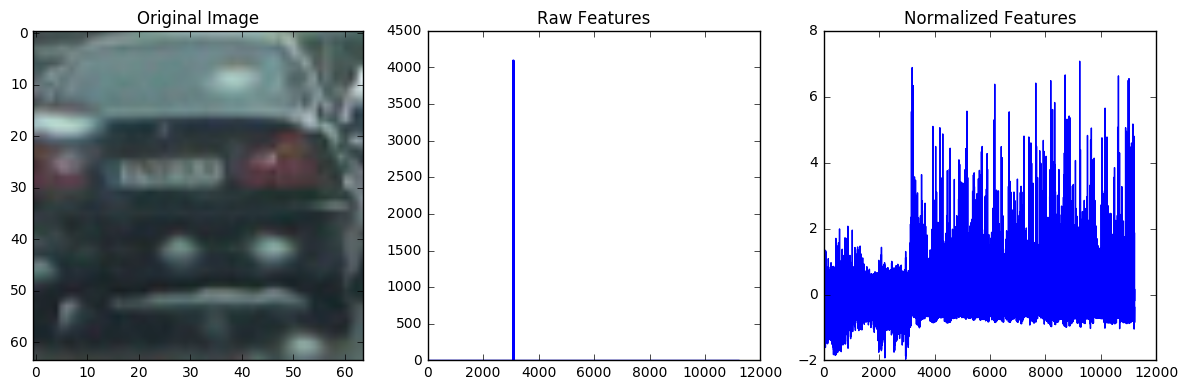

In [45]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 4 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

t=time.time() 
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract features...')

if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
    # Visualization
    car_ind = np.random.randint(0, len(cars))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(cars[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
else: 
    print('Your function only returns empty feature vectors...')

In [46]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Feature vector length: 11220
31.85 Seconds to train SVC...
Test Accuracy of SVC =  0.9805
My SVC predicts:  [ 0.  1.  1.  1.  0.  0.  0.  0.  1.  0.]
For these 10 labels:  [ 0.  1.  1.  1.  0.  0.  0.  0.  1.  0.]
0.00073 Seconds to predict 10 labels with SVC


In [47]:
# Save the data for easy access
pickle_file = 'model.pickle'
print('Saving data to pickle file...')
try:
    with open(pickle_file, 'wb') as pfile:
        pickle.dump(
            {
                'model': svc,
                'scaler': X_scaler,
                'color_space': color_space,
                'orient': orient,
                'pix_per_cell': pix_per_cell,
                'cell_per_block': cell_per_block,
                'hog_channel': hog_channel,
                'spatial_size': spatial_size,
                'hist_bins': hist_bins,
                'spatial_feat': spatial_feat,
                'hist_feat': hist_feat,
                'hog_feat': hog_feat,
            }, 
            pfile, 
            pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise
print('Data cached in pickle file.')

Saving data to pickle file...
Data cached in pickle file.


In [48]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from utils import *
from scipy.ndimage.measurements import label
from collections import deque
%matplotlib inline

In [49]:
# Reload the data
pickle_file = 'model.pickle'
with open(pickle_file, 'rb') as f:
    pickle_data = pickle.load(f)
    print(pickle_data)
    svc = pickle_data['model']
    X_scaler = pickle_data['scaler']
    color_space = pickle_data['color_space'] # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = pickle_data['orient']  # HOG orientations
    pix_per_cell = pickle_data['pix_per_cell'] # HOG pixels per cell
    cell_per_block = pickle_data['cell_per_block'] # HOG cells per block
    hog_channel = pickle_data['hog_channel'] # Can be 0, 1, 2, or "ALL"
    spatial_size = pickle_data['spatial_size'] # Spatial binning dimensions
    hist_bins = pickle_data['hist_bins']    # Number of histogram bins
    spatial_feat = pickle_data['spatial_feat'] # Spatial features on or off
    hist_feat = pickle_data['hist_feat'] # Histogram features on or off
    hog_feat = pickle_data['hog_feat'] # HOG features on or off
    
print('Model loaded.')

{'hog_channel': 0, 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True), 'hog_feat': True, 'spatial_feat': True, 'pix_per_cell': 4, 'orient': 9, 'hist_feat': True, 'model': LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0), 'hist_bins': 16, 'cell_per_block': 2, 'color_space': 'YCrCb', 'spatial_size': (32, 32)}
Model loaded.


In [50]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
        
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [51]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5), window_list = []):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, score_thresh = 20.0,
                    spatial_feat=True, hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    scores = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier        
        test_features = scaler.transform(features)
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        score = abs(clf.decision_function(test_features).round(2))
        #7) If positive (prediction == 1) then save the window
        if prediction == 1 and score <= score_thresh:
            on_windows.append(window)
            scores.append(score)
    #8) Return windows for positive detections
    return on_windows, scores

In [52]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap < threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        width = abs(bbox[1][0] - bbox[0][0])
        height = abs(bbox[1][1] - bbox[0][1])    
        # Draw the box on the image
        if (width >= img.shape[1] / 20 and height >= img.shape[0] / 20):
            cv2.rectangle(img, bbox[0], bbox[1], (0, 255, 0), 6)
    # Return the image
    return img


560


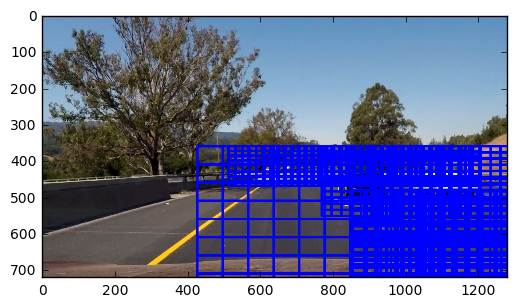

In [53]:
image = mpimg.imread('test_images/test6.jpg')                    
draw_image1 = np.copy(image)
draw_image2 = np.copy(image)
draw_image3 = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
image = image.astype(np.float32)/255

window_list = [] 

# x_start_stop = [image.shape[1] * 3 // 5, image.shape[1] * 9 // 10] # Min and max in x to search in slide_window()
# y_start_stop = [image.shape[0] * 1 // 2, image.shape[0] * 3 // 5] # Min and max in y to search in slide_window()
# window_list = slide_window(image, x_start_stop = x_start_stop, y_start_stop=y_start_stop, 
#                    xy_window=(100, 70), xy_overlap=(0.8, 0.8), window_list = window_list)

# x_start_stop = [image.shape[1] * 3 // 5, None] # Min and max in x to search in slide_window()
# y_start_stop = [image.shape[0] * 1 // 2, image.shape[0] * 7 // 10] # Min and max in y to search in slide_window()
# window_list = slide_window(image, x_start_stop = x_start_stop, y_start_stop=y_start_stop, 
#                    xy_window=(140, 90), xy_overlap=(0.8, 0.8), window_list = window_list)

# x_start_stop = [image.shape[1] * 2 // 3, None] # Min and max in x to search in slide_window()
# y_start_stop = [image.shape[0] * 2 // 3, None] # Min and max in y to search in slide_window()
# window_list = slide_window(image, x_start_stop = x_start_stop, y_start_stop=y_start_stop, 
#                    xy_window=(160, 100), xy_overlap=(0.8, 0.8), window_list = window_list)

# x_start_stop = [image.shape[1] * 2 // 3, None] # Min and max in x to search in slide_window()
# y_start_stop = [image.shape[0] * 2 // 3, None] # Min and max in y to search in slide_window()
# window_list = slide_window(image, x_start_stop = x_start_stop, y_start_stop=y_start_stop, 
#                     xy_window=(180, 130), xy_overlap=(0.8, 0.8), window_list = window_list)

# x_start_stop = [image.shape[1] * 2 // 3, None] # Min and max in x to search in slide_window()
# y_start_stop = [image.shape[0] * 2 // 3, None] # Min and max in y to search in slide_window()
# window_list = slide_window(image, x_start_stop = x_start_stop, y_start_stop=y_start_stop, 
#                     xy_window=(200, 150), xy_overlap=(0.8, 0.8), window_list = window_list)

# x_start_stop = [image.shape[1] * 1 // 3, image.shape[1] * 2 // 3] # Min and max in x to search in slide_window()
# y_start_stop = [image.shape[0] * 1 // 2, image.shape[1] * 1 // 2] # Min and max in y to search in slide_window()
# window_list = slide_window(image, x_start_stop = x_start_stop, y_start_stop=y_start_stop, 
#                     xy_window=(320, 240), xy_overlap=(0.8, 0.8), window_list = window_list)

x_start_stop = [image.shape[1] * 2 // 5, image.shape[1] * 9 // 10] # Min and max in x to search in slide_window()
y_start_stop = [image.shape[0] * 1 // 2, image.shape[0] * 3 // 5] # Min and max in y to search in slide_window()
window_list = slide_window(image, x_start_stop = x_start_stop, y_start_stop=y_start_stop, 
                   xy_window=(100, 70), xy_overlap=(0.8, 0.8), window_list = window_list)

x_start_stop = [image.shape[1] * 3 // 5, None] # Min and max in x to search in slide_window()
y_start_stop = [image.shape[0] * 1 // 2, image.shape[0] * 7 // 10] # Min and max in y to search in slide_window()
window_list = slide_window(image, x_start_stop = x_start_stop, y_start_stop=y_start_stop, 
                   xy_window=(140, 90), xy_overlap=(0.8, 0.8), window_list = window_list)

x_start_stop = [image.shape[1] * 2 // 3, None] # Min and max in x to search in slide_window()
y_start_stop = [image.shape[0] * 2 // 3, None] # Min and max in y to search in slide_window()
window_list = slide_window(image, x_start_stop = x_start_stop, y_start_stop=y_start_stop, 
                   xy_window=(160, 100), xy_overlap=(0.8, 0.8), window_list = window_list)

x_start_stop = [image.shape[1] * 2 // 3, None] # Min and max in x to search in slide_window()
y_start_stop = [image.shape[0] * 2 // 3, None] # Min and max in y to search in slide_window()
window_list = slide_window(image, x_start_stop = x_start_stop, y_start_stop=y_start_stop, 
                    xy_window=(180, 130), xy_overlap=(0.8, 0.8), window_list = window_list)

x_start_stop = [image.shape[1] * 2 // 3, None] # Min and max in x to search in slide_window()
y_start_stop = [image.shape[0] * 2 // 3, None] # Min and max in y to search in slide_window()
window_list = slide_window(image, x_start_stop = x_start_stop, y_start_stop=y_start_stop, 
                    xy_window=(200, 150), xy_overlap=(0.8, 0.8), window_list = window_list)

x_start_stop = [image.shape[1] * 1 // 3, image.shape[1] * 2 // 3] # Min and max in x to search in slide_window()
y_start_stop = [image.shape[0] * 1 // 2, None] # Min and max in y to search in slide_window()
window_list = slide_window(image, x_start_stop = x_start_stop, y_start_stop=y_start_stop, 
                    xy_window=(280, 200), xy_overlap=(0.75, 0.75), window_list = window_list)



print(len(window_list))

window_img1 = draw_boxes(draw_image1, window_list, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img1)

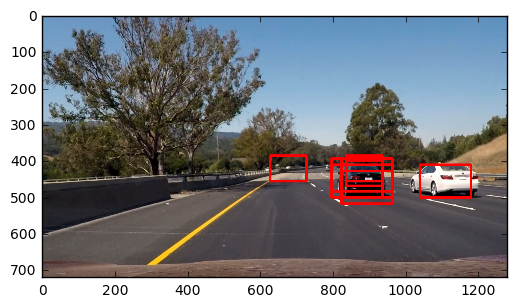

In [54]:
hot_windows, scores = search_windows(image, window_list, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, score_thresh = 5,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img2 = draw_boxes(draw_image2, hot_windows, color=(255, 0, 0), thick=6)    
plt.imshow(window_img2)

1 cars found


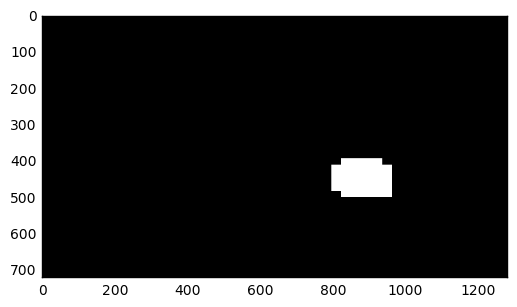

In [55]:
heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
heatmap = add_heat(heatmap, hot_windows)
heatmap = apply_threshold(heatmap, 2)
labels = label(heatmap)
print(labels[1], 'cars found')
plt.imshow(labels[0], cmap='gray')

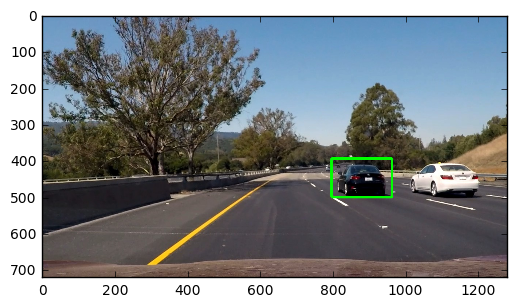

In [56]:
# Draw bounding boxes on a copy of the image
draw_img = draw_labeled_bboxes(draw_image3, labels)
# Display the image
plt.imshow(draw_img)

In [57]:
def process_image(image):
    draw_image1 = np.copy(image)
    draw_image2 = np.copy(image)
    
    
    heatmap = np.zeros_like(image[:,:,0])
    image = image.astype(np.float32)/255
    #print(np.max(image))
    
    hot_windows, scores = search_windows(image, window_list, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, score_thresh = 5,
                            spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = draw_boxes(draw_image1, hot_windows, color=(255, 0, 0), thick=6)        
    
    
    
    heatmap = add_heat(heatmap, hot_windows)

    
    heatmaps.append(heatmap)
    hm = sum(heatmaps)
    hm = apply_threshold(hm, 8)
    
    labels = label(hm)
    font = cv2.FONT_HERSHEY_SIMPLEX
    num_str = str(labels[1]) + " car(s) found" 
    cv2.putText(draw_image2, num_str, (10, 50), font, 1, (255, 255, 255), 2)    

    draw_img = draw_labeled_bboxes(draw_image2, labels)
    
    window_img = cv2.cvtColor(window_img, cv2.COLOR_RGB2BGR)
    result = np.copy(draw_img)
    result = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)
    
    cv2.imshow('window_img', window_img)
    cv2.imshow('heatmap', hm)
    cv2.imshow('output', result)
    cv2.waitKey(1)
    
    return draw_img

In [58]:
heatmaps = deque(maxlen = 10)

output_video = 'vehicle_tracking.mp4'
input_video = VideoFileClip("project_video.mp4")
output_clip = input_video.fl_image(process_image) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video vehicle_tracking.mp4
[MoviePy] Writing video vehicle_tracking.mp4


100%|█████████▉| 1260/1261 [31:25<00:01,  1.44s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: vehicle_tracking.mp4 

CPU times: user 2h 9min 4s, sys: 28.1 s, total: 2h 9min 32s
Wall time: 31min 25s


In [59]:
HTML("""
<video width="640" height="320" controls>
  <source src="{0}">
</video>
""".format(output_video))